## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

## Data Load

In [2]:
df = pd.read_csv('/Users/jian_lee/Desktop/aiffel/data/bike-sharing-demand/train.csv')

In [3]:
# datetime 컬럼을 datetime 자료형으로 변환
df['datetime'] = pd.to_datetime(df['datetime'])

# 연, 월, 일, 시, 분, 초 컬럼 생성
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second

# 결과 확인
print(df.head())

             datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  year  month  day  hour  \
0        81        0.0       3          13     16  2011      1    1     0   
1        80        0.0       8          32     40  2011      1    1     1   
2        80        0.0       5          27     32  2011      1    1     2   
3        75        0.0       3          10     13  2011      1    1     3   
4        75        0.0       0           1      1  2011      1    1     4   

   minute  second  
0       0       0  
1       0       0  
2       0     

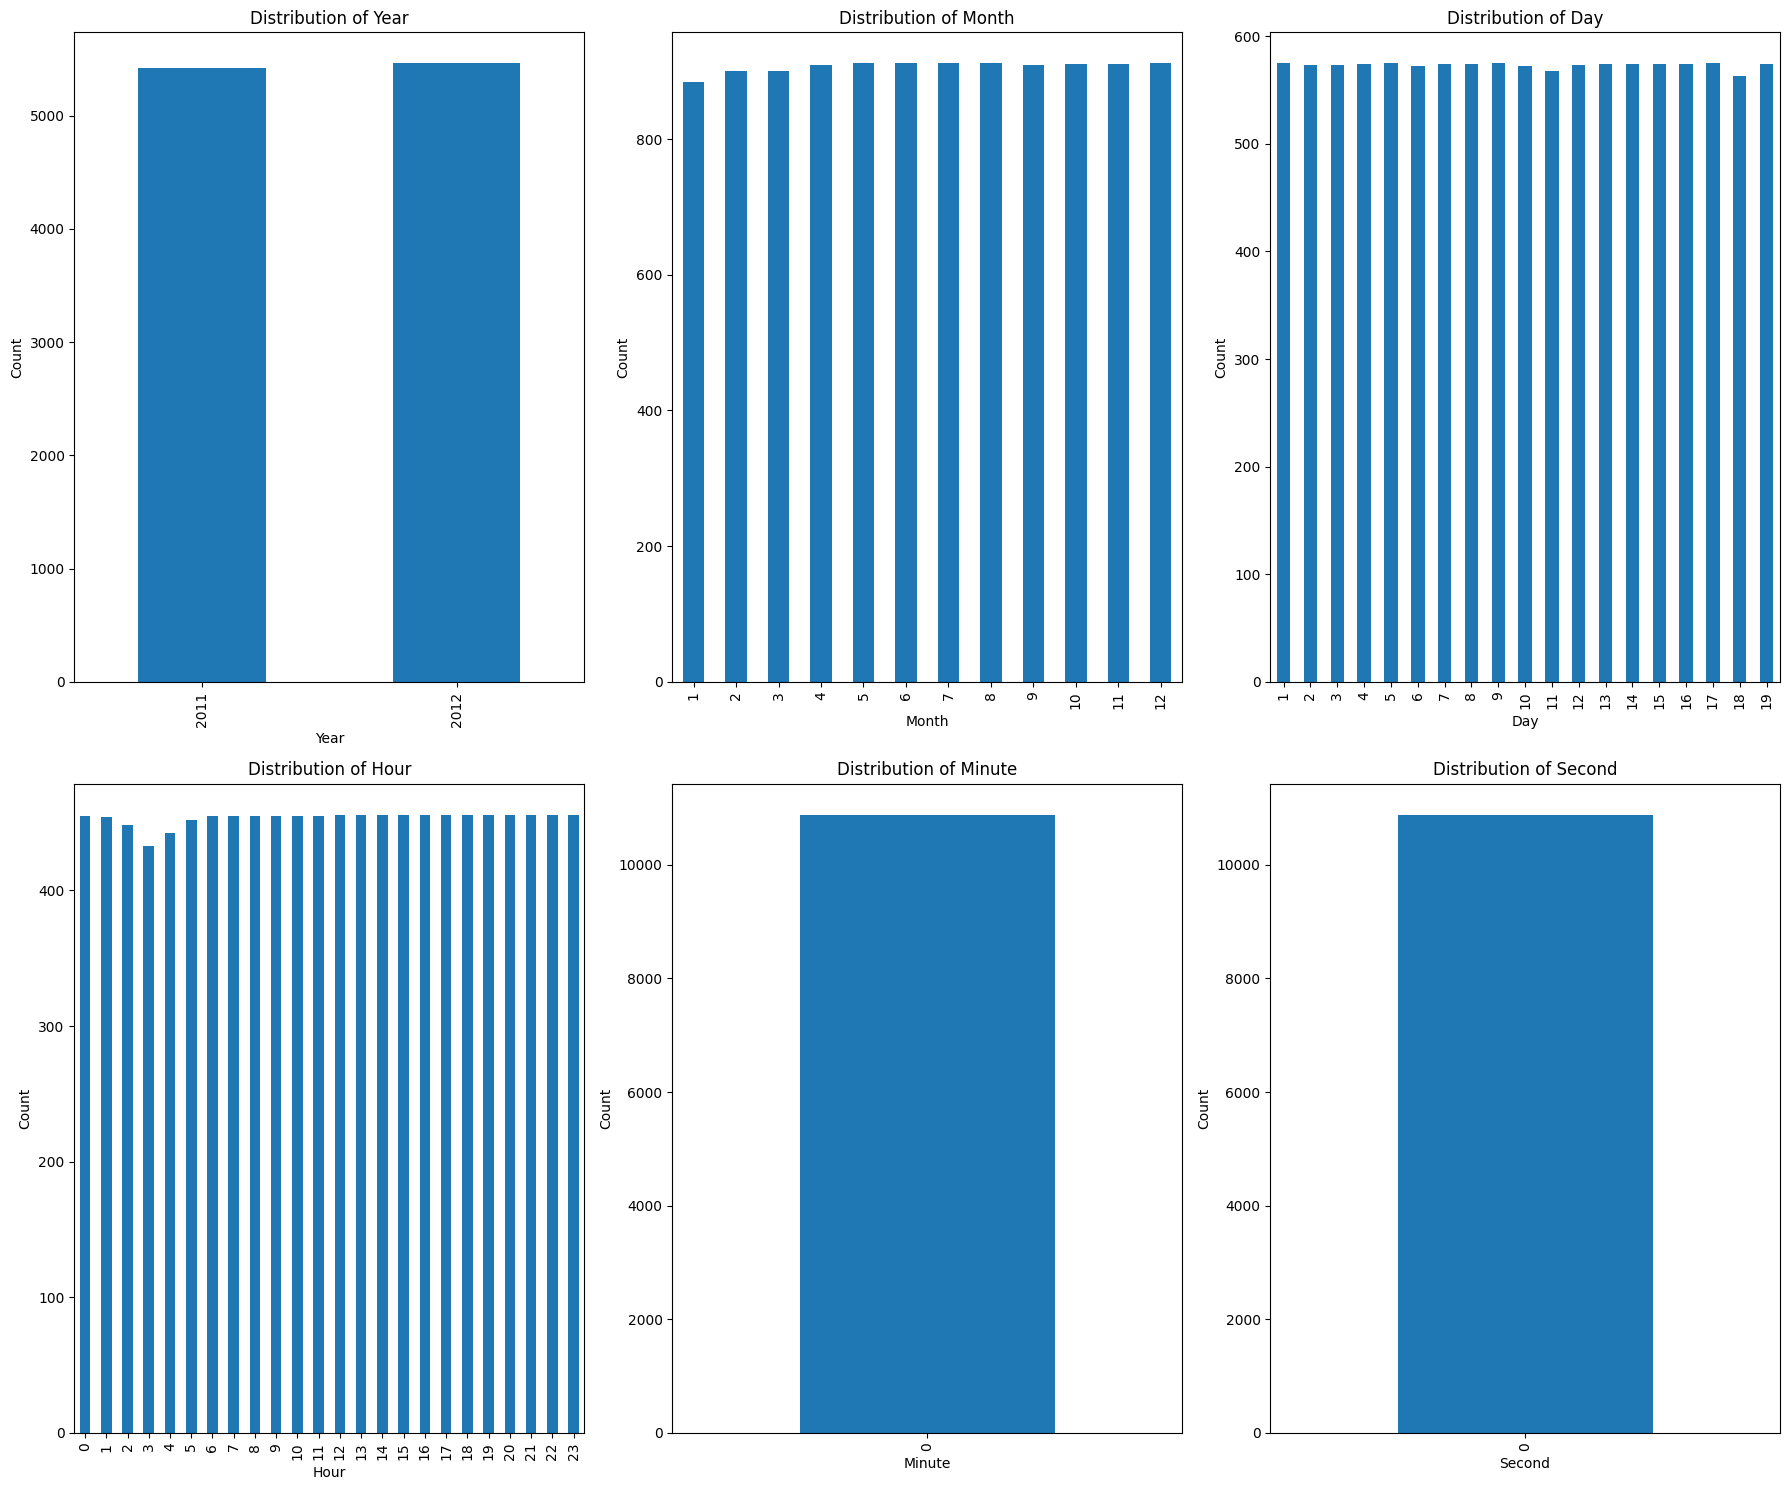

In [4]:
# 시각화 함수
columns = ['year', 'month', 'day', 'hour', 'minute', 'second']

# 3x3 그리드 생성
fig, axes = plt.subplots(2, 3, figsize=(18, 15))

# 컬럼별 시각화
for idx, col in enumerate(columns):
    row, col_pos = divmod(idx, 3)
    df[col].value_counts().sort_index().plot(kind='bar', ax=axes[row, col_pos])
    axes[row, col_pos].set_title(f'Distribution of {col.capitalize()}')
    axes[row, col_pos].set_xlabel(col.capitalize())
    axes[row, col_pos].set_ylabel('Count')

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

In [5]:
# 연속형 변수 선택
continuous_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']

# 이상치 탐지 및 제거 함수
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)  # 1분위수 (25%)
        Q3 = df[col].quantile(0.75)  # 3분위수 (75%)
        IQR = Q3 - Q1  # IQR 계산
        lower_bound = Q1 - 1.5 * IQR  # 하한
        upper_bound = Q3 + 1.5 * IQR  # 상한
        
        # 이상치 제거
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        
        print(f"{col} - 이상치 제거 후 남은 데이터 수: {len(df)}")
    return df

# 이상치 제거
df_cleaned = remove_outliers_iqr(df, continuous_columns)

# 결과 확인
print("이상치 제거 후 데이터프레임 크기:", df_cleaned.shape)

temp - 이상치 제거 후 남은 데이터 수: 10886
atemp - 이상치 제거 후 남은 데이터 수: 10886
humidity - 이상치 제거 후 남은 데이터 수: 10864
windspeed - 이상치 제거 후 남은 데이터 수: 10638
casual - 이상치 제거 후 남은 데이터 수: 9901
registered - 이상치 제거 후 남은 데이터 수: 9383
count - 이상치 제거 후 남은 데이터 수: 9364
이상치 제거 후 데이터프레임 크기: (9364, 18)


## 데이터 분리

In [6]:
# X와 y 컬럼 선택
X = df.drop(['datetime', 'count', 'casual', 'registered'], axis=1)  # datetime과 타깃 변수(count) 제외
y = df['count']  # 타깃 변수

In [7]:
# train/test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 확인
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8708, 14)
X_test shape: (2178, 14)
y_train shape: (8708,)
y_test shape: (2178,)


In [8]:
# StandardScaler를 학습 데이터에 fit
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 테스트 데이터에 transform 적용
X_test_scaled = scaler.transform(X_test)

In [9]:
# Polynomial Features (다항 회귀 적용)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Ridge & Lasso 모델 준비
ridge = Ridge()
lasso = Lasso()

# GridSearchCV로 하이퍼파라미터 튜닝
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

ridge_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')

# Ridge 모델 학습 및 평가
ridge_search.fit(X_train_poly, y_train)
ridge_best_model = ridge_search.best_estimator_

# Lasso 모델 학습 및 평가
lasso_search.fit(X_train_poly, y_train)
lasso_best_model = lasso_search.best_estimator_

# 최종 평가 (Ridge, Lasso)
ridge_pred = ridge_best_model.predict(X_test_poly)
lasso_pred = lasso_best_model.predict(X_test_poly)

ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.840e+06, tolerance: 2.310e+04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.531e+05, tolerance: 2.278e+04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

In [10]:
# Ridge 모델 예측
y_pred_ridge = ridge_best_model.predict(X_test_poly)

# Lasso 모델 예측
y_pred_lasso = lasso_best_model.predict(X_test_poly)

# Ridge 모델 손실 함수 값 계산
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)

# Lasso 모델 손실 함수 값 계산
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)

In [11]:
# 결과 출력
print("Ridge Model:")
print("MSE:", mse_ridge)
print("RMSE:", rmse_ridge)

print("\nLasso Model:")
print("MSE:", mse_lasso)
print("RMSE:", rmse_lasso)

Ridge Model:
MSE: 14460.188765800916
RMSE: 120.25052501257912

Lasso Model:
MSE: 14444.445556591898
RMSE: 120.1850471422793


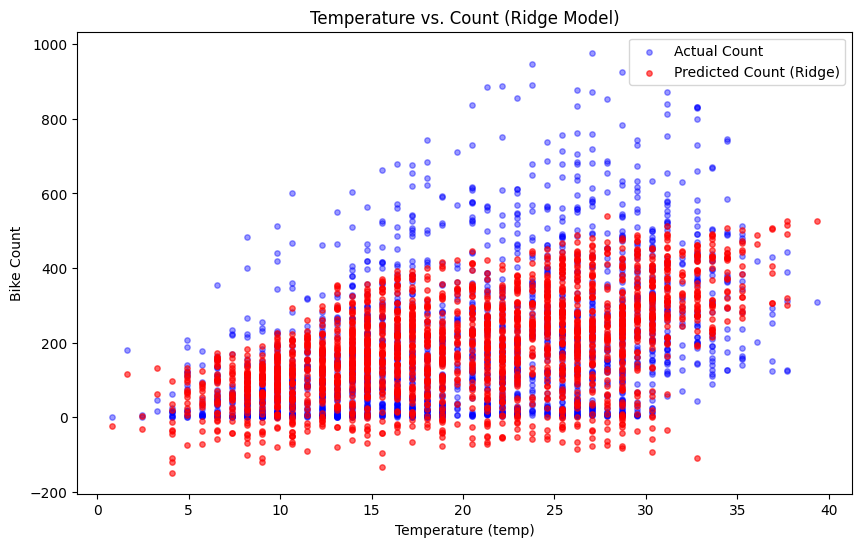

In [12]:
import matplotlib.pyplot as plt

# Ridge 모델 예측값 준비
y_pred_ridge = ridge_best_model.predict(X_test_poly)

# X_test에서 temp와 예측값, 실제값을 사용하여 시각화
plt.figure(figsize=(10, 6))

# 점 크기(s)와 투명도(alpha) 조정
plt.scatter(X_test['temp'], y_test, label='Actual Count', color='blue', alpha=0.4, s=15)
plt.scatter(X_test['temp'], y_pred_ridge, label='Predicted Count (Ridge)', color='red', alpha=0.6, s=15)

plt.title('Temperature vs. Count (Ridge Model)')
plt.xlabel('Temperature (temp)')
plt.ylabel('Bike Count')
plt.legend()
plt.show()